# Tutorial 13: Bayesian Deep Learning

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under%20development&color=red)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial13/Bayesian_Deep_Learning.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial13/Bayesian_Deep_Learning.ipynb)  
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial13)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1BmisSPs5BXQKpolyHp5X4klSAhpDx479?usp=sharing)

Links:
* https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd
* https://towardsdatascience.com/blitz-a-bayesian-neural-network-library-for-pytorch-82f9998916c7
* Dataset: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

In [3]:
## Standard libraries
import os
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:  # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial13"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = []
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/",1)[1])
    if "/" in file_name.split("/",1)[1]:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Regression

### Toy dataset: sine

In [44]:
def generate_sine_data(num_points=100, min_val=-5, max_val=5, noise_std=0.3):
    x = torch.zeros(num_points).uniform_(min_val, max_val)
    y = x_to_sine(x) + torch.randn(num_points) * noise_std
    return x, y

def x_to_sine(x):
    return torch.sin(x/0.5)+x*0.2

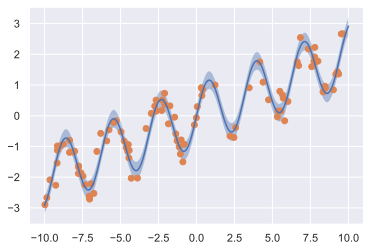

In [45]:
def visualize_sine_data(num_points=100, min_val=-10, max_val=10, noise_std=0.3):
    x, y = generate_sine_data(num_points, min_val, max_val, noise_std)
    x_sin = torch.linspace(min_val, max_val, 200)
    y_sin = x_to_sine(x_sin)
    sns.set()
    plt.plot(x_sin, y_sin)
    plt.fill_between(x_sin, y_sin-noise_std, y_sin+noise_std, alpha=0.4)
    plt.scatter(x, y)
    plt.show()
    
visualize_sine_data()

In [ ]:
train_dataset = data.TensorDataset(generate_sine_data(num_points=500))

In [ ]:
class RegressorMLP(nn.Module):
    
    def __init__(self, in_features, out_features, hidden_features, act_fn=nn.LeakyReLU):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            act_fn(),
            nn.Linear(hidden_features, hidden_features),
            act_fn(),
            nn.Linear(hidden_features, out_features)
        )
    
    def forward(self, x):
        return self.mlp(x)

## Bayesian Image Classification

In [5]:
class OurCNN(nn.Module):
    
    def __init__(self, c_in=1, c_hid=32, num_classes=10, act_fn=nn.SiLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.AdaptiveAvgPool2d(),
            nn.Flatten(),
            nn.Linear(2*c_hid, 2*c_hid),
            act_fn(),
            nn.Linear(2*c_hid, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

In [7]:
class CNNTrainer(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.model = OurCNN()
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
        
    def _eval_batch(self, imgs, labels, mode='train'):
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss, acc
        
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        loss, _ = self._eval_batch(imgs, labels, mode='train')
        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        self._eval_batch(imgs, labels, mode='val')
    
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        self._eval_batch(imgs, labels, mode='test')